In [1]:
# Library imports
import geopandas as gpd
import osmnx as ox
import networkx as nx
import momepy
import matplotlib.pyplot as plt
import folium
import pandas as pd
import overpy
from shapely.geometry import LineString
from shapely.geometry import Point
import requests
from shapely.geometry import MultiPolygon
import statistics

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [101]:
# update osmnx settings
useful_tags_ways = ox.settings.useful_tags_way + ['cycleway'] + ['bicycle'] + ['motor_vehicle'] + ['railway'] + ['tunnel'] + ['barrier'] + ['bus'] + ['access'] + ['oneway'] + ['oneway:bicycle'] + ['covered'] 
ox.config(use_cache=True, 
          log_console=True,
          useful_tags_way=useful_tags_ways
          )
# read in UK road gpkg
#os_open_roads = gpd.read_file(r"C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\ltnDetection\LTN-Detection\data\oproad_gpkg_gb\Data\oproad_roads_only.gpkg")
# read in UK rivers gpkg
#os_open_rivers = gpd.read_file(r"C:\Users\b8008458\OneDrive - Newcastle University\2022 to 2023\PhD\ltnDetection\LTN-Detection\data\oproad_gpkg_gb\Data\oprvrs_watercourse_only.gpkg")
# set location and get boundary
place = "Newcastle Upon Tyne, United Kingdom"
boundary = ox.geocode_to_gdf(place)
boundary = boundary.to_crs('EPSG:27700')

# buffer boundary to ensure clips include riverlines which may act as borders between geographies
boundary_buffered = boundary.buffer(50)
## get railways

# for unknown reasons, using rail = ox.graph_from_place(place, custom_filter='["railway"]')
# doesn't ALWAYS retrive the full rail network, hence why multiple lines are used to achive the same result

# Get the major rail network
railway_types = ["","rail", "light_rail", "narrow_gauge", "subway", "tram"]

# set an empty
combined_railways = nx.MultiDiGraph()

for railway_type in railway_types:
    try:
        network = ox.graph_from_place(place, simplify=False 
                                      , custom_filter=f'["railway"~"{railway_type}"]'
                                      )
    
    # handle locations where not all rail types are found
    except Exception as e:
        print(f"No railway data found for '{railway_type}'.")
        network = nx.MultiGraph()

    combined_railways = nx.compose(combined_railways, network)
    


# convert to gdf
railways = ox.graph_to_gdfs(combined_railways, nodes=False, edges=True)




# Drop any other railway types that aren't needed
railways = railways.loc[(~railways["railway"].isin(["tunnel", "abandoned", "razed", "disused", "funicular", "monorail", "miniature"]))]

# set railways crs
railways = railways.to_crs('EPSG:27700')
## get unsuitable landcover types

# reset boundary crs to allow for features to be found
boundary_buffered = boundary_buffered.to_crs('EPSG:4326')

# Define tags
tags = {"landuse": ["industrial", "railway", "brownfield", "commercial", "farmland", "meadow"]}

# Use ox.features_from_polygon to find features matching the specified tags
landuse = ox.features_from_polygon(polygon = boundary_buffered.iloc[0], tags = tags)

# set/reset crs
landuse = landuse.to_crs('27700')

## get unsuitable "nature" types

# Define tags
tags = {"natural": ["wood", "water", "scrub"]}

# Use ox.features_from_polygon to find features matching the specified tags
nature = ox.features_from_polygon(polygon = boundary_buffered.iloc[0], tags = tags)

# set/reset crs
nature = nature.to_crs('27700')

## get unsuitable "lesiure" types. This is mainly for golfcourses

# Define tags
tags = {"leisure": ["golf_course", "track", "park"]}

# Use ox.features_from_polygon to find features matching the specified tags
leisure = ox.features_from_polygon(polygon = boundary_buffered.iloc[0], tags = tags)

# set/reset crs
leisure = leisure.to_crs('27700')
boundary_buffered = boundary_buffered.to_crs('27700')

# concat
landuse = pd.concat([landuse, nature, leisure])


## get bus routes from OSM/NAPTAN

# reset boundary crs to allow for features to be found
boundary_buffered = boundary_buffered.to_crs('EPSG:4326')

# Calculate the bounding box for XML query
bounding_box = boundary_buffered.bounds

# Extract the minimum and maximum coordinates
minx = bounding_box['minx'].min()
miny = bounding_box['miny'].min()
maxx = bounding_box['maxx'].max()
maxy = bounding_box['maxy'].max()

# Create a list of four elements representing the bounding box
bbox = [minx, miny, maxx, maxy]

# reset boundary_buffer crs
boundary_buffered = boundary_buffered.to_crs('27700')

# Define the Overpass API endpoint
overpass_url = "https://overpass-api.de/api/interpreter"

# Define the XML query
xml_query = f"""
<osm-script output="json" output-config="" timeout="160">
  <union into="_">
    <query into="_" type="node">
      <has-kv k="route" modv="" v="bus"/>
      <bbox-query s="{bbox[1]}" w="{bbox[0]}" n="{bbox[3]}" e="{bbox[2]}" />
    </query>
    <query into="_" type="way">
      <has-kv k="route" modv="" v="bus"/>
      <bbox-query s="{bbox[1]}" w="{bbox[0]}" n="{bbox[3]}" e="{bbox[2]}" />
    </query>
    <query into="_" type="relation">
      <has-kv k="route" modv="" v="bus"/>
      <bbox-query s="{bbox[1]}" w="{bbox[0]}" n="{bbox[3]}" e="{bbox[2]}" />
    </query>
  </union>
  <print e="" from="_" geometry="full" ids="yes" limit="" mode="body" n="" order="id" s="" w=""/>
  <recurse from="_" into="_" type="down"/>
  <print e="" from="_" geometry="full" ids="yes" limit="" mode="skeleton" n="" order="quadtile" s="" w=""/>
</osm-script>

"""
# Initialize lists to store data
geometries = []
element_data = []

# Make the Overpass API request
response = requests.post(overpass_url, data=xml_query)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()
    
    # Access the data from the response
    for element in data.get("elements", []):
        if element.get('type') == 'way' and 'geometry' in element:
            # Extract geometry coordinates from 'geometry' field
            coordinates = [(node['lon'], node['lat']) for node in element['geometry']]
            # Create a LineString geometry
            line = LineString(coordinates)
            geometries.append(line)
            element_data.append(element)

    # Create a GeoDataFrame
    bus_routes = gpd.GeoDataFrame(element_data, geometry=geometries)

    # Set CRS
    bus_routes = bus_routes.set_crs('4326')
    bus_routes = bus_routes.to_crs('27700')

else:
    print(f"Error fetching data: {response.status_code} - {response.text}")
## clip roads, rivers and railways to boundary

# clip
os_open_roads_clip = gpd.clip(os_open_roads, boundary_buffered)
os_open_rivers_clip = gpd.clip(os_open_rivers, boundary_buffered)
railways_clip = gpd.clip(railways, boundary_buffered)
landuse_clip = gpd.clip(landuse, boundary_buffered)
bus_routes_clip = gpd.clip(bus_routes, boundary_buffered)
## count bus routes per road and remove roads with greater than 1 bus route on them

# set a buffer distance to convert roads to polygons
buffer_distance = 0.2  # Adjust this value as needed. Set in meters

# Create a new GeoDataFrame with the buffered geometries
bus_routes_buffered = bus_routes_clip.copy()  # Copy the original GeoDataFrame
bus_routes_buffered['geometry'] = bus_routes_buffered['geometry'].buffer(buffer_distance)

# count the number of overlapping bus routes
def count_overlapping_features(gdf):
    # Create an empty column to store the count of overlapping features
    gdf['Bus_routes_count'] = 0

    # Iterate through each row in the GeoDataFrame
    for idx, row in gdf.iterrows():
        # Get the geometry of the current row
        geometry = row['geometry']
        
        # Use a spatial filter to find overlapping features
        overlaps = gdf[gdf['geometry'].intersects(geometry)]
        
        # Update the Bus_routes_count column with the count of overlapping features
        gdf.at[idx, 'Bus_routes_count'] = len(overlaps)
    
    return gdf

# call function
bus_routes_buffered_with_count = count_overlapping_features(bus_routes_buffered)

# drop any roads which have less than two bus routes on them

bus_routes_clip = bus_routes_buffered_with_count[bus_routes_buffered_with_count['Bus_routes_count'] >= 2]

# Find "neighbourhood" roads
neighbourhoods = os_open_roads_clip.loc[~((os_open_roads_clip['primary_route'] == 'True') |
                        (os_open_roads_clip['trunk_road'] == 'True') |
                        (os_open_roads_clip['fictitious'] == 'True') |
                        (os_open_roads_clip['road_classification'] == 'A Road') | 
                        (os_open_roads_clip['road_classification'] == 'B Road') | 
                        (os_open_roads_clip['road_function'] == 'Restricted Local Access Road') |
                        (os_open_roads_clip['road_function'] == 'Minor Road') |
                        (os_open_roads_clip['road_function'] == 'Motorway') |
                        (os_open_roads_clip['road_function'] == 'Minor Road') 
                        )]
# Find "boundary" roads
boundary_roads = os_open_roads_clip.loc[((os_open_roads_clip['primary_route'] == 'True') |
                        (os_open_roads_clip['trunk_road'] == 'True') |
                        (os_open_roads_clip['fictitious'] == 'True') |
                        (os_open_roads_clip['road_classification'] == 'A Road') | 
                        (os_open_roads_clip['road_classification'] == 'B Road') | 
                        #(os_open_roads_clip['road_function'] == 'Restricted Local Access Road') |
                        (os_open_roads_clip['road_function'] == 'Minor Road') |
                        (os_open_roads_clip['road_function'] == 'Motorway') |
                        (os_open_roads_clip['road_function'] == 'Minor Road')  
                        )]
## buffering and dissolving functions
 
def buffer_and_dissolve(input_gdf):
    # Buffer around boundaries
    buffered_gdf = input_gdf.copy()  # Create a copy to avoid modifying the original
    buffered_gdf['geometry'] = buffered_gdf['geometry'].buffer(5) # set a 5 meter buffer

    # Dissolve the geometries
    dissolved_geo = buffered_gdf.unary_union

    # Create a new GeoDataFrame with the dissolved geometry
    dissolved_gdf = gpd.GeoDataFrame(geometry=[dissolved_geo])

    # Set the CRS (Coordinate Reference System)
    dissolved_gdf.crs = input_gdf.crs

    return dissolved_gdf

def dissolve_gdf(input_gdf):
    # dissolve geometries
    dissolved_geo = input_gdf.unary_union
    dissolved_gdf = gpd.GeoDataFrame(geometry=[dissolved_geo])
    dissolved_gdf.crs = input_gdf.crs

    return dissolved_gdf
# buffer and dissolve 

boundary_roads_bd = buffer_and_dissolve(boundary_roads)
boundary_rivers_bd = buffer_and_dissolve(os_open_rivers_clip)
boundary_rail_bd = buffer_and_dissolve(railways_clip)
boundary_landuse_bd = buffer_and_dissolve(landuse_clip)
boundary_bus_routes_bd = buffer_and_dissolve(bus_routes_clip)
# join all boundary features

boundaries = pd.concat([boundary_rivers_bd 
                        ,boundary_roads_bd 
                        ,boundary_rail_bd 
                        #,boundary_landuse_bd
                        ,boundary_bus_routes_bd
                        ], ignore_index=True)
boundary_features = dissolve_gdf(boundaries)
# Use the `difference` method to perform the "Erase" operation
erased_boundary = boundary.difference(boundary_features.unary_union)

# Convert the GeoSeries to a single geometry using unary_union
erased_boundary = erased_boundary.unary_union

# Create a new GeoDataFrame with the result of "Erase" operation
erased_boundary_gdf = gpd.GeoDataFrame(geometry=[erased_boundary], crs=boundary.crs)

# explode multipolygon to polygons
erased_boundary_gdf = erased_boundary_gdf.explode()

neighbourhoods = erased_boundary_gdf
## drop very small areas (such as the centre of roundabouts etc)

# calculate area
neighbourhoods["area"] = neighbourhoods.geometry.area
# Drop rows where area is less than 5000. This value is arbitary
neighbourhoods = neighbourhoods.loc[neighbourhoods["area"] >= 10000]
neighbourhoods.explore()
## drop areas with no roads


def count_roads_within_polygons(polygons_gdf, roads_gdf, polygon_column_name):
    """
    Count the number of roads within each polygon in a GeoDataFrame.
    
    Args:
        polygons_gdf (GeoDataFrame): GeoDataFrame containing polygons.
        roads_gdf (GeoDataFrame): GeoDataFrame containing roads.
        polygon_column_name (str): Name of the column in polygons_gdf to use for grouping.

    Returns:
        GeoDataFrame: Original polygons GeoDataFrame with a "road_count" column added.
    """
    
    # spatial join
    joined = gpd.sjoin(polygons_gdf, roads_gdf, how='left', op='intersects')
    
    # Group by the polygon column and count the number of roads in each
    road_counts = joined.groupby(polygon_column_name).size().reset_index(name='road_count')
    
    # Merge the road counts back into the polygons GeoDataFrame
    polygons_gdf = polygons_gdf.merge(road_counts, on=polygon_column_name, how='left')

     # Calculate road density (area divided by road_count). It is mulitiplied by 10000 for ease of understanding the numbers involved with this
    polygons_gdf['road_density'] = (polygons_gdf['road_count'] / polygons_gdf['area'] ) * 10000
    
    return polygons_gdf

neighbourhoods = count_roads_within_polygons(neighbourhoods, os_open_roads_clip, 'geometry')

# Drop rows with road_density below 0.2 or less than 4 roads
neighbourhoods = neighbourhoods[(neighbourhoods['road_count'] > 2)]
neighbourhoods = neighbourhoods[(neighbourhoods['road_density'] > 0.2)]
## create unique IDs

# simple number based ID
neighbourhoods['ID'] = range(1, len(neighbourhoods) + 1)

neighbourhoods.explore()



C:\Users\b8008458\AppData\Local\Temp\ipykernel_12424\2856370427.py:3: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True,


No railway data found for 'narrow_gauge'.
No railway data found for 'subway'.
No railway data found for 'tram'.


C:\Users\b8008458\AppData\Local\Temp\ipykernel_12424\2856370427.py:287: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  erased_boundary_gdf = erased_boundary_gdf.explode()
c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3505: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [123]:
## get just Heaton

neighbourhood = neighbourhoods[neighbourhoods['ID'] == 2]

neighbourhood.explore()

In [124]:
### build a network surrounding the neighbourhood

## create a buffer around the edge of the neighbourhood to capture boundary roads

# set crs
neighbourhood = neighbourhood.to_crs('27700')

# create a buffer neighbourhood
neighbourhood_buffer = neighbourhood['geometry'].buffer(15)

# convert back to a geodataframe (for later on)
neighbourhood_buffer = gpd.GeoDataFrame(geometry=neighbourhood_buffer)

# reset crs
neighbourhood, neighbourhood_buffer = neighbourhood.to_crs('4326'), neighbourhood_buffer.to_crs('4326')


## get street network
streets = ox.graph_from_polygon(neighbourhood_buffer.geometry.iloc[0], network_type='all')

# Convert the OSMnx graph to a GeoDataFrame of streets
streets_edges = ox.graph_to_gdfs(streets, nodes=False, edges=True)
streets_nodes = ox.graph_to_gdfs(streets, nodes=True, edges=False)

In [125]:
### Find only driveable nodes

#Filter edges with desired 'highway' attributes containing any keyword in drive_highway_types
drive_highway_types = ['tertiary', 'secondary', 'primary', 'unclassed', 'residential', 'primary_link', 'secondary_link', 'tertiary_link', 'living_street', 'service', 'road']

# Function to check if any desired keyword is in the 'highway' attribute
def contains_desired_highway_type(highway_attr):
    for keyword in drive_highway_types:
        if keyword in highway_attr:
            return True
    return False

# Apply the function to create a boolean mask
mask = streets_edges['highway'].apply(contains_desired_highway_type)
driveable_edges = streets_edges[mask]

# Extract unique node identifiers from the MultiIndex columns 'u' and 'v' of filtered edges
u_nodes = driveable_edges.index.get_level_values('u').tolist()
v_nodes = driveable_edges.index.get_level_values('v').tolist()
driveable_nodes = set(u_nodes + v_nodes)

# Filter nodes based on their connection to filtered edges
driveable_nodes_gdf = streets_nodes[streets_nodes.index.isin(driveable_nodes)]


In [126]:
## find the boundary roads using 

# Calculate the difference between neighbourhood_buffer and neighbourhood
neighbourhood_difference = gpd.overlay(neighbourhood_buffer, neighbourhood, how='difference')

# find all nodes within the buffer
boundary_nodes = gpd.sjoin(driveable_nodes_gdf, neighbourhood_difference, how="inner", op='within')

# Extract nodes from the 'boundary_nodes' index
nodes_list = list(boundary_nodes.index)

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [127]:
## function to calcualte the accessiabilty per neighbourhood


def calculate_distance_stats(network):
    all_pairs_shortest_paths = {}
    nodes_list = list(network.nodes())

    for start_node in nodes_list:
        shortest_paths = nx.single_source_dijkstra_path_length(network, start_node, weight='length')
        all_pairs_shortest_paths[start_node] = shortest_paths

    distances = [length for paths in all_pairs_shortest_paths.values() for length in paths.values()]

    mean_distance = statistics.mean(distances)
    median_distance = statistics.median(distances)
    min_distance = min(distances)
    max_distance = max(distances)
    distance_range = max_distance - min_distance

    return {
        "mean_distance": mean_distance,
        "median_distance": median_distance,
        "min_distance": min_distance,
        "max_distance": max_distance,
        "distance_range": distance_range
    }



In [128]:
## get mode based networks
bike_streets = ox.graph_from_polygon(neighbourhood_buffer.geometry.iloc[0], network_type='bike')
walk_streets = ox.graph_from_polygon(neighbourhood_buffer.geometry.iloc[0], network_type='walk')
drive_streets = ox.graph_from_polygon(neighbourhood_buffer.geometry.iloc[0], network_type='drive')

In [133]:
walk_stats = calculate_distance_stats(walk_streets)
bike_stats = calculate_distance_stats(bike_streets)
drive_stats = calculate_distance_stats(drive_streets)

# Add the statistics to the GeoDataFrame
neighbourhood['walk_mean_distance'] = walk_stats['mean_distance']
neighbourhood['walk_median_distance'] = walk_stats['median_distance']
neighbourhood['walk_min_distance'] = walk_stats['min_distance']
neighbourhood['walk_max_distance'] = walk_stats['max_distance']
neighbourhood['walk_distance_range'] = walk_stats['distance_range']

neighbourhood['bike_mean_distance'] = bike_stats['mean_distance']
neighbourhood['bike_median_distance'] = bike_stats['median_distance']
neighbourhood['bike_min_distance'] = bike_stats['min_distance']
neighbourhood['bike_max_distance'] = bike_stats['max_distance']
neighbourhood['bike_distance_range'] = bike_stats['distance_range']

neighbourhood['drive_mean_distance'] = drive_stats['mean_distance']
neighbourhood['drive_median_distance'] = drive_stats['median_distance']
neighbourhood['drive_min_distance'] = drive_stats['min_distance']
neighbourhood['drive_max_distance'] = drive_stats['max_distance']
neighbourhood['drive_distance_range'] = drive_stats['distance_range']

In [137]:
neighbourhood.explore()

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


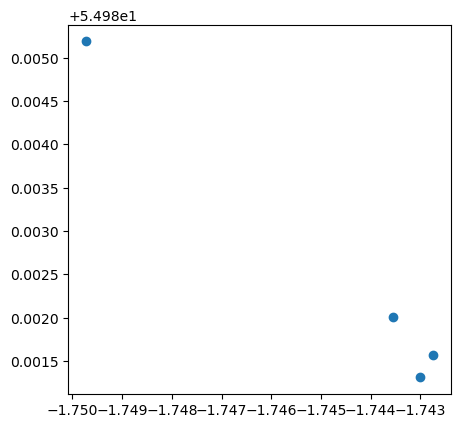

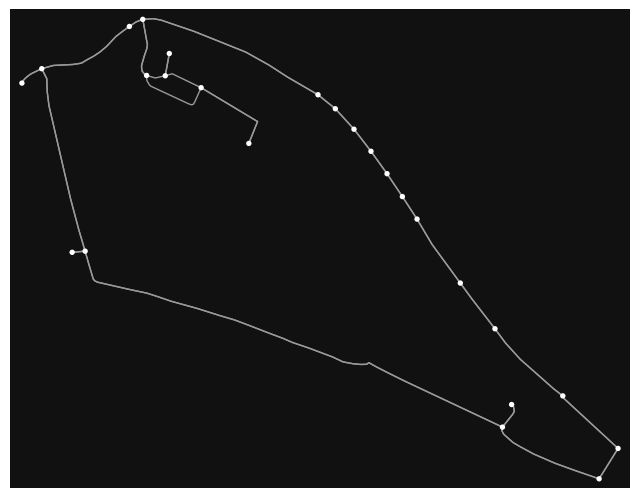

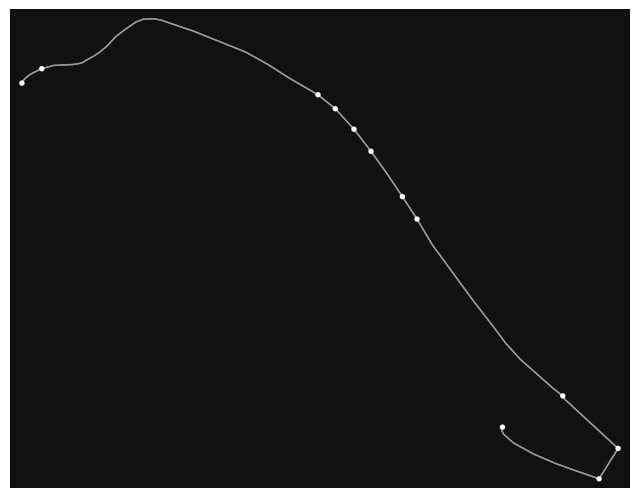

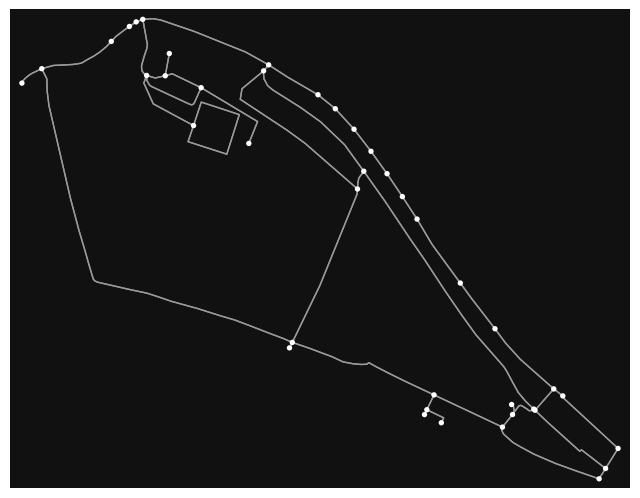

In [139]:

# set crs
neighbourhood = neighbourhood.to_crs('27700')

# create a buffer neighbourhood
neighbourhood_buffer = neighbourhood['geometry'].buffer(15)

# convert back to a geodataframe (for later on)
neighbourhood_buffer = gpd.GeoDataFrame(geometry=neighbourhood_buffer)

# reset crs
neighbourhood, neighbourhood_buffer = neighbourhood.to_crs('4326'), neighbourhood_buffer.to_crs('4326')


## get street network
streets = ox.graph_from_polygon(neighbourhood_buffer.geometry.iloc[0], network_type='bike')

# Convert the OSMnx graph to a GeoDataFrame of streets
streets_edges = ox.graph_to_gdfs(streets, nodes=False, edges=True)
streets_nodes = ox.graph_to_gdfs(streets, nodes=True, edges=False)






### Find only driveable nodes

#Filter edges with desired 'highway' attributes containing any keyword in drive_highway_types
drive_highway_types = ['tertiary', 'secondary', 'primary', 'unclassed', 'residential', 'primary_link', 'secondary_link', 'tertiary_link', 'living_street', 'service', 'road']

# Function to check if any desired keyword is in the 'highway' attribute
def contains_desired_highway_type(highway_attr):
    for keyword in drive_highway_types:
        if keyword in highway_attr:
            return True
    return False

# Apply the function to create a boolean mask
mask = streets_edges['highway'].apply(contains_desired_highway_type)
driveable_edges = streets_edges[mask]

# Extract unique node identifiers from the MultiIndex columns 'u' and 'v' of filtered edges
u_nodes = driveable_edges.index.get_level_values('u').tolist()
v_nodes = driveable_edges.index.get_level_values('v').tolist()
driveable_nodes = set(u_nodes + v_nodes)

# Filter nodes based on their connection to filtered edges
driveable_nodes_gdf = streets_nodes[streets_nodes.index.isin(driveable_nodes)]










## find the boundary roads using 

# Calculate the difference between neighbourhood_buffer and neighbourhood
neighbourhood_difference = gpd.overlay(neighbourhood_buffer, neighbourhood, how='difference')

# find all nodes within the buffer
boundary_nodes = gpd.sjoin(driveable_nodes_gdf, neighbourhood_difference, how="inner", op='within')

# Extract nodes from the 'boundary_nodes' index
nodes_list = list(boundary_nodes.index)




boundary_nodes.plot()




## get mode based networks
bike_streets = ox.graph_from_polygon(neighbourhood_buffer.geometry.iloc[0], network_type='bike')
walk_streets = ox.graph_from_polygon(neighbourhood_buffer.geometry.iloc[0], network_type='walk')
drive_streets = ox.graph_from_polygon(neighbourhood_buffer.geometry.iloc[0], network_type='drive')

ox.plot_graph(bike_streets)
ox.plot_graph(drive_streets)
ox.plot_graph(walk_streets)




walk_stats = calculate_distance_stats(walk_streets)
bike_stats = calculate_distance_stats(bike_streets)
drive_stats = calculate_distance_stats(drive_streets)

# Add the statistics to the GeoDataFrame
neighbourhood['walk_mean_distance'] = walk_stats['mean_distance']
neighbourhood['walk_median_distance'] = walk_stats['median_distance']
neighbourhood['walk_min_distance'] = walk_stats['min_distance']
neighbourhood['walk_max_distance'] = walk_stats['max_distance']
neighbourhood['walk_distance_range'] = walk_stats['distance_range']

neighbourhood['bike_mean_distance'] = bike_stats['mean_distance']
neighbourhood['bike_median_distance'] = bike_stats['median_distance']
neighbourhood['bike_min_distance'] = bike_stats['min_distance']
neighbourhood['bike_max_distance'] = bike_stats['max_distance']
neighbourhood['bike_distance_range'] = bike_stats['distance_range']

neighbourhood['drive_mean_distance'] = drive_stats['mean_distance']
neighbourhood['drive_median_distance'] = drive_stats['median_distance']
neighbourhood['drive_min_distance'] = drive_stats['min_distance']
neighbourhood['drive_max_distance'] = drive_stats['max_distance']
neighbourhood['drive_distance_range'] = drive_stats['distance_range']



c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


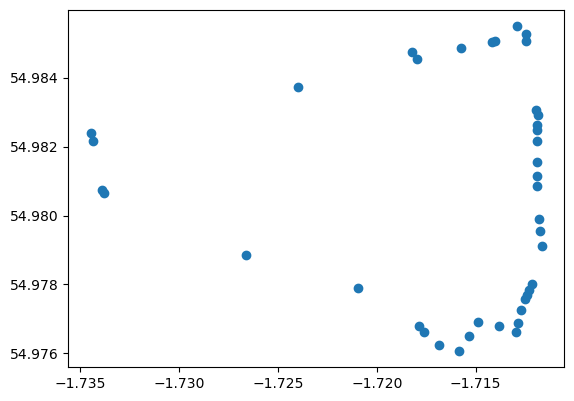

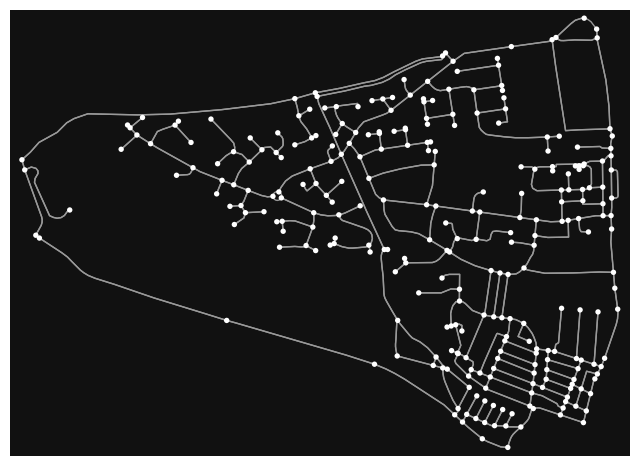

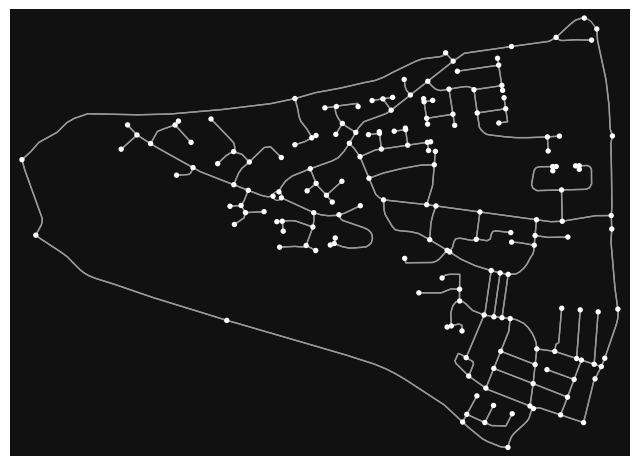

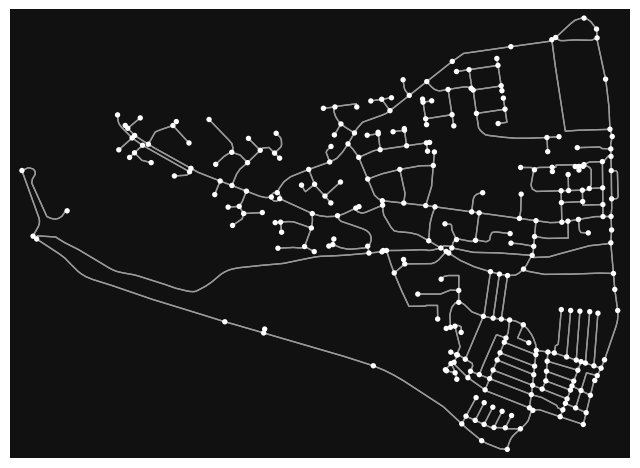

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


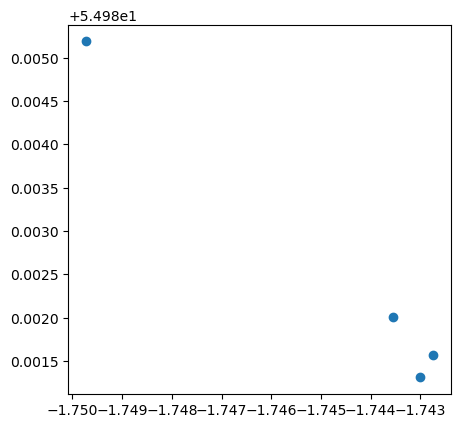

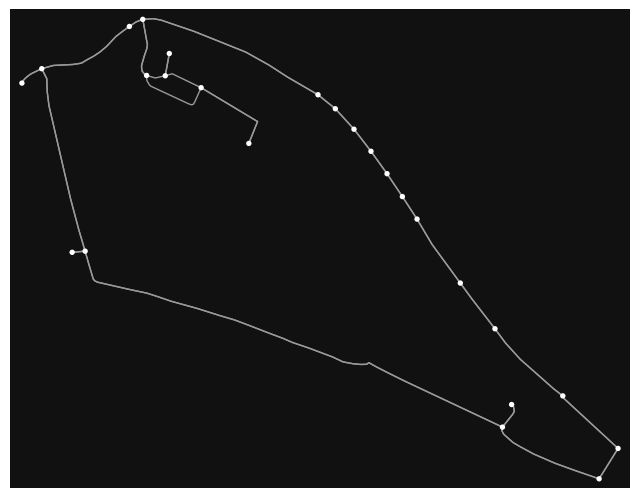

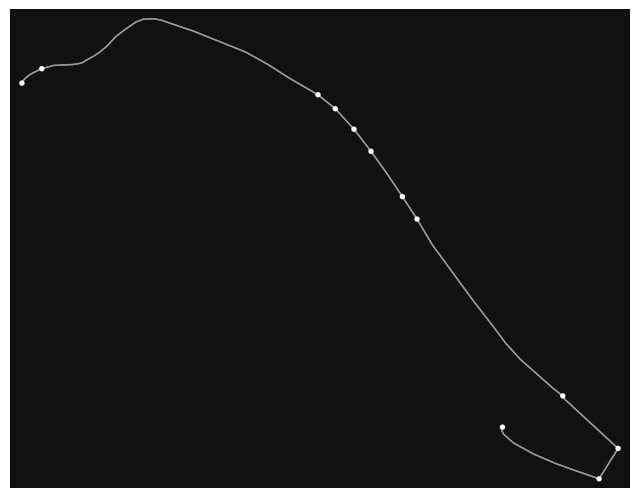

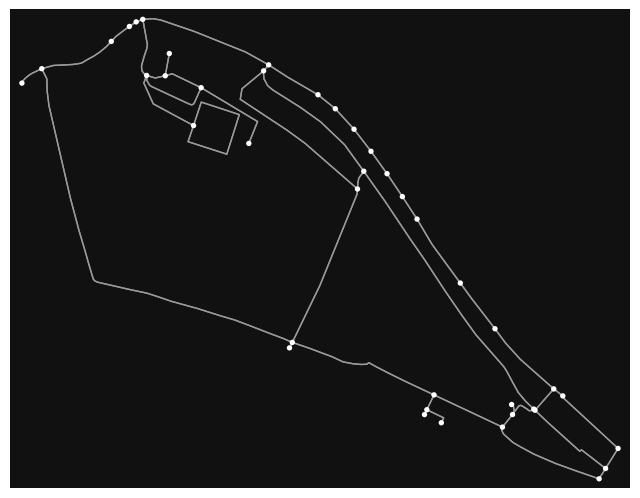

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


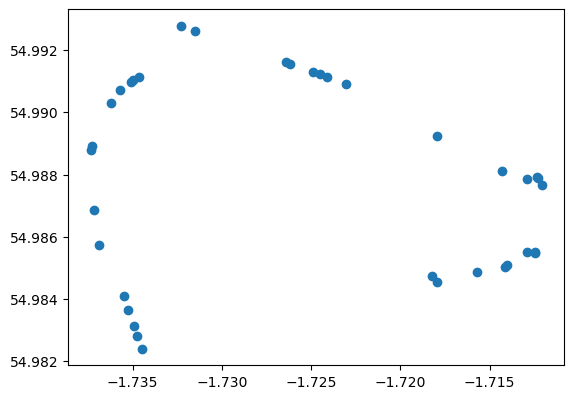

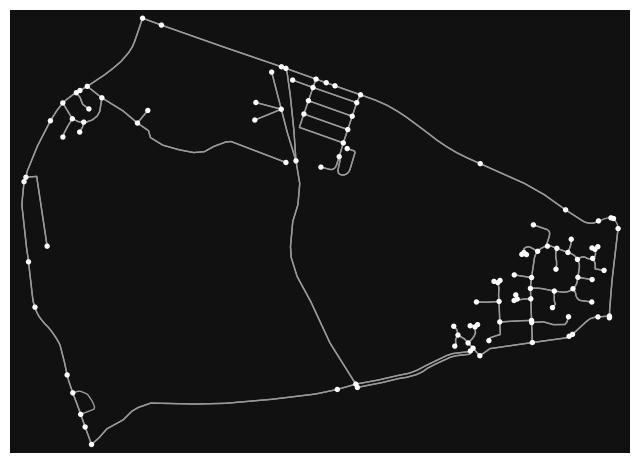

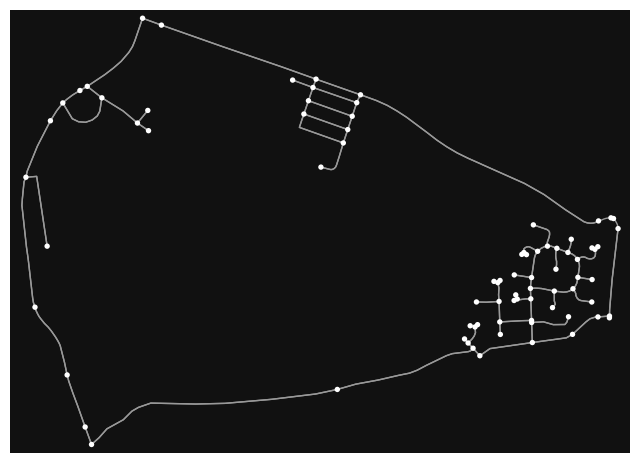

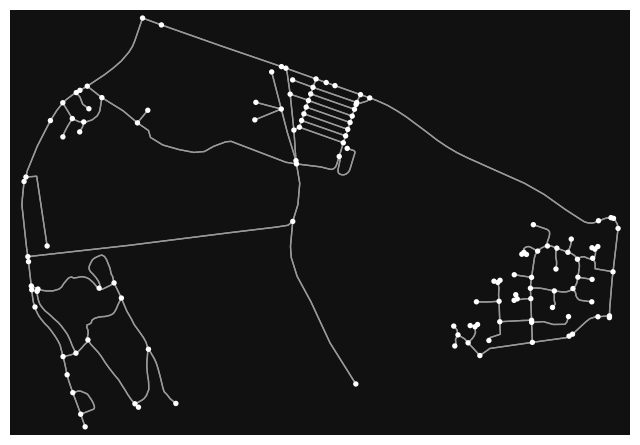

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


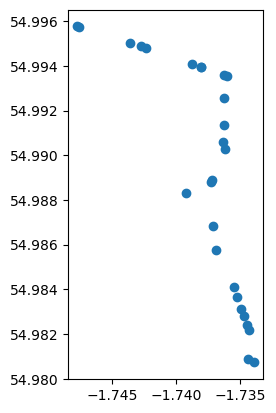

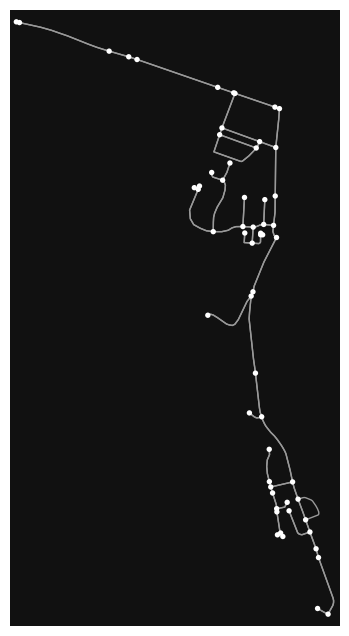

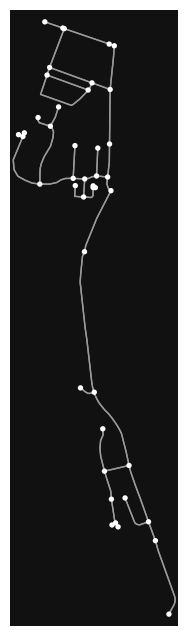

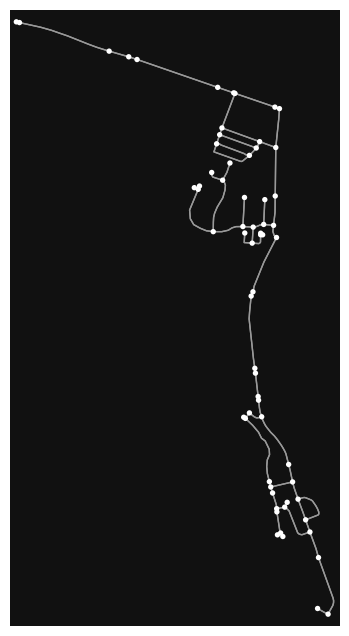

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


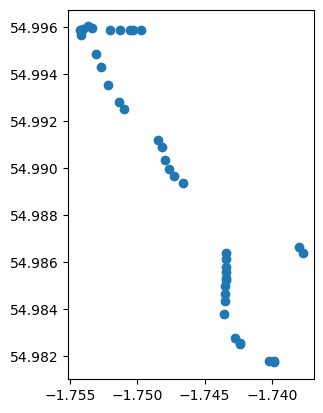

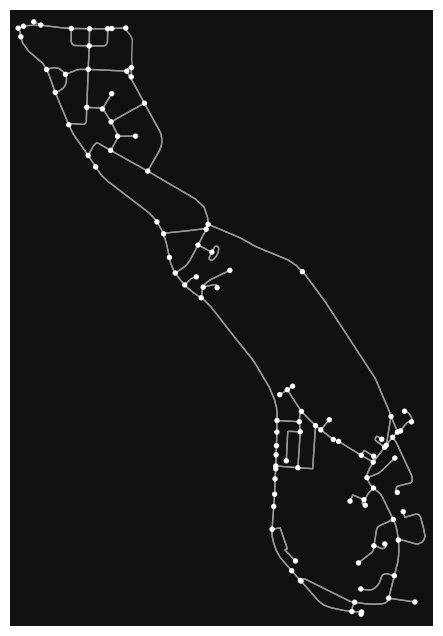

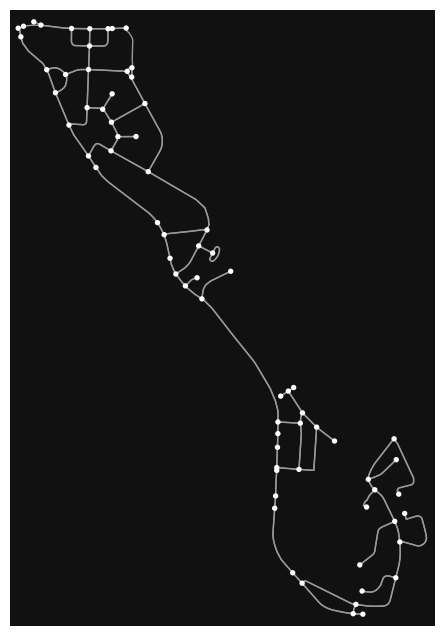

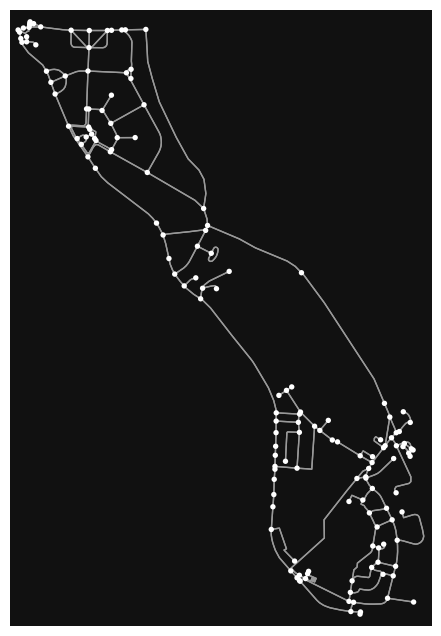

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


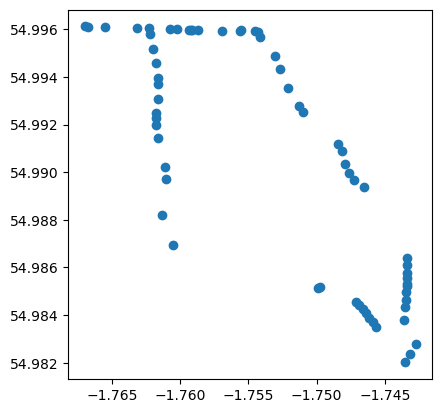

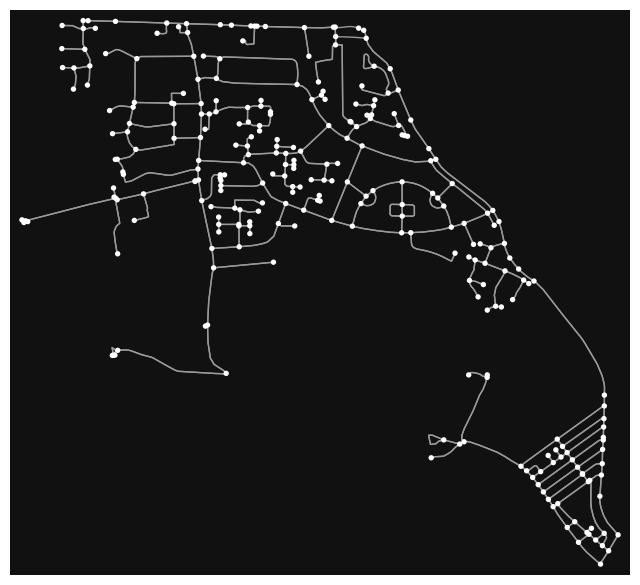

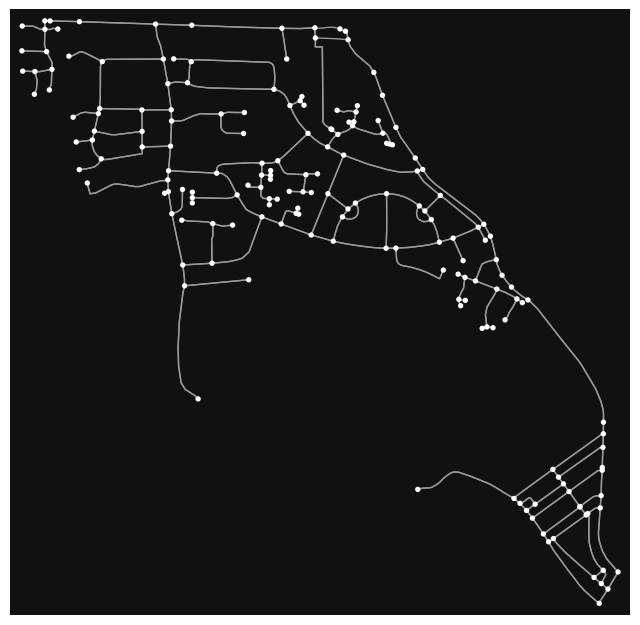

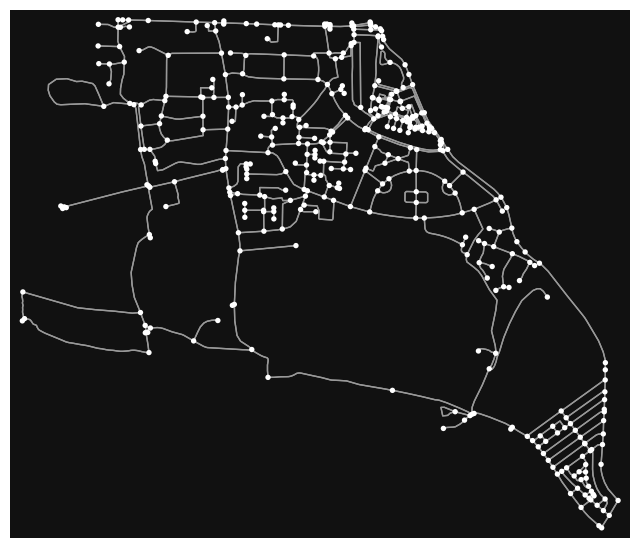

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


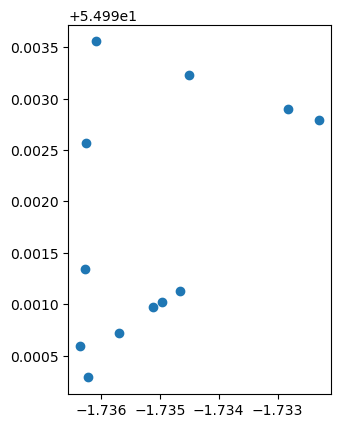

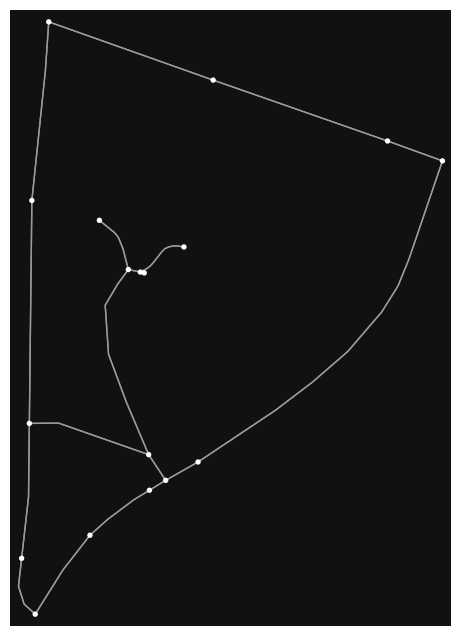

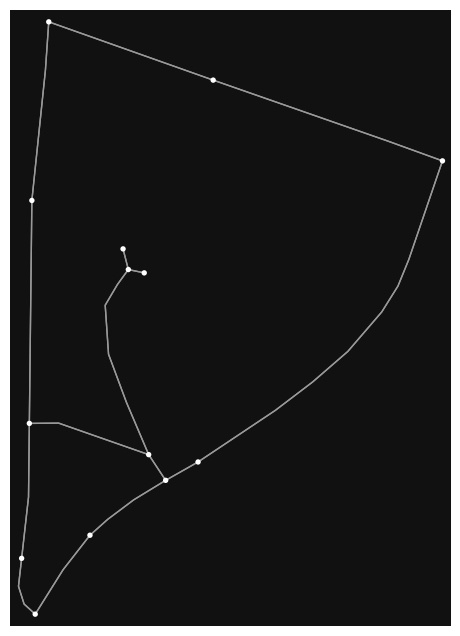

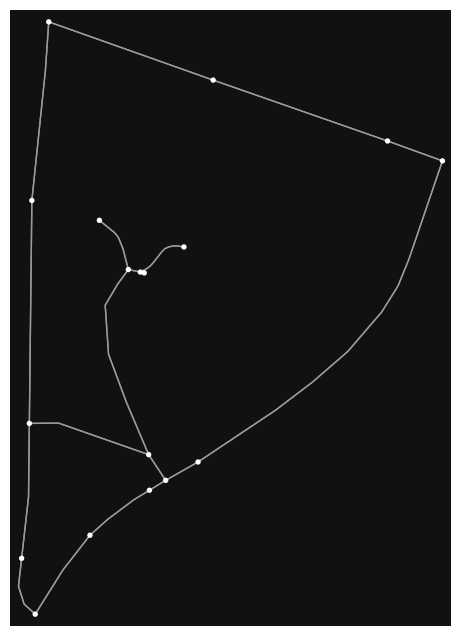

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


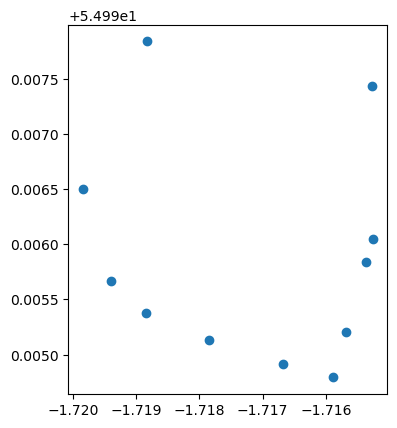

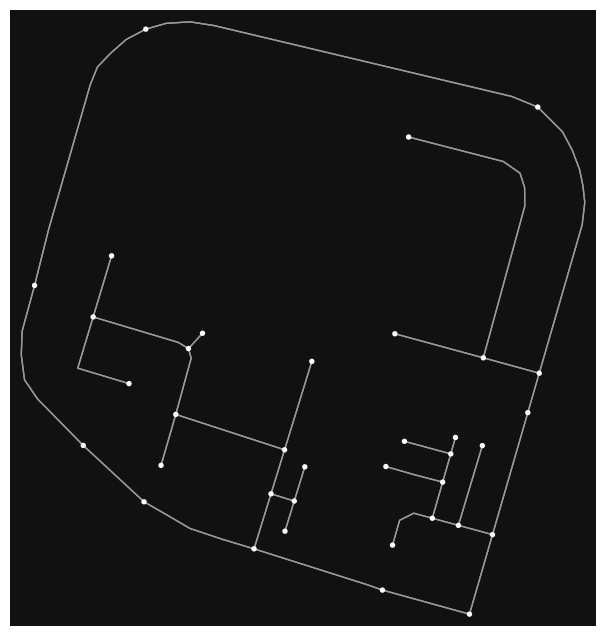

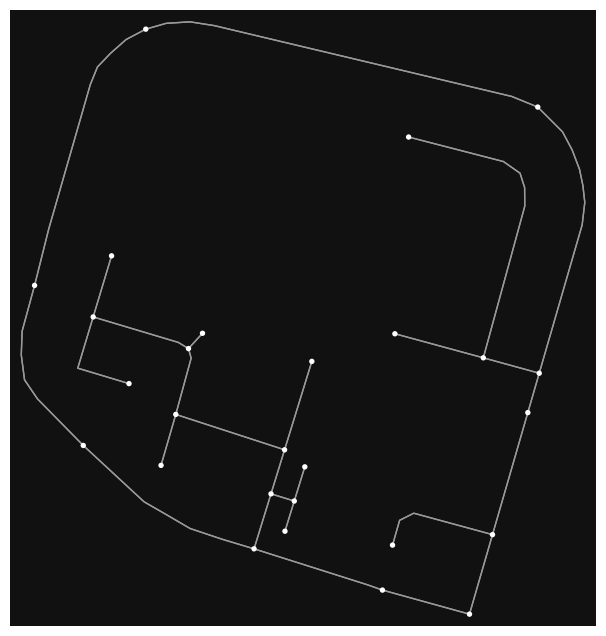

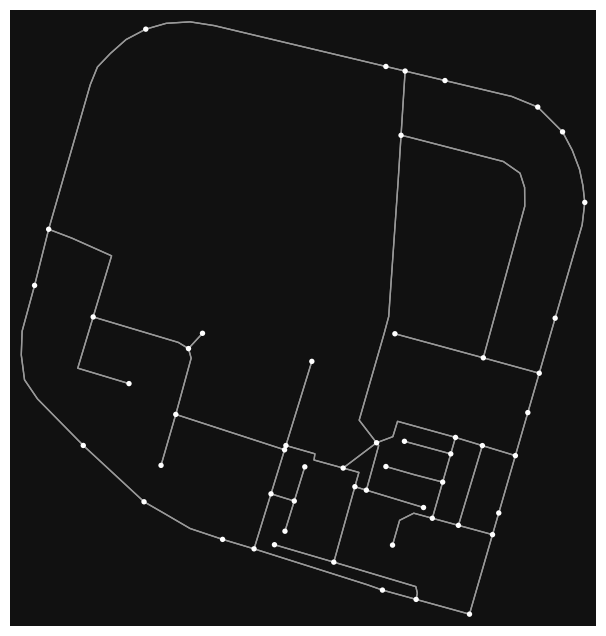

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


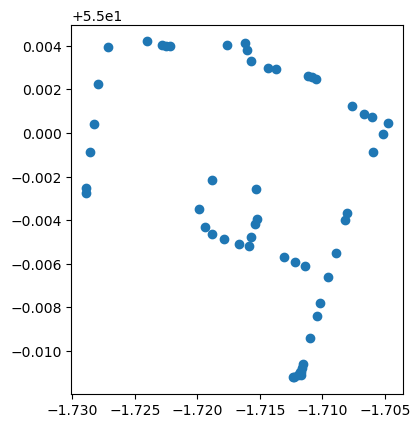

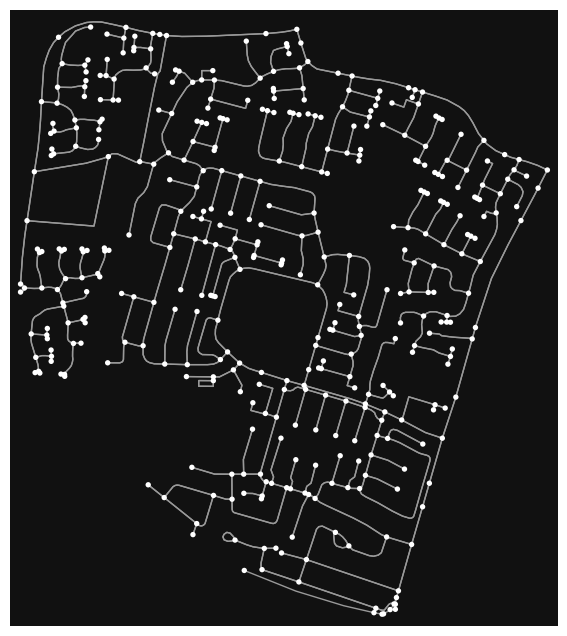

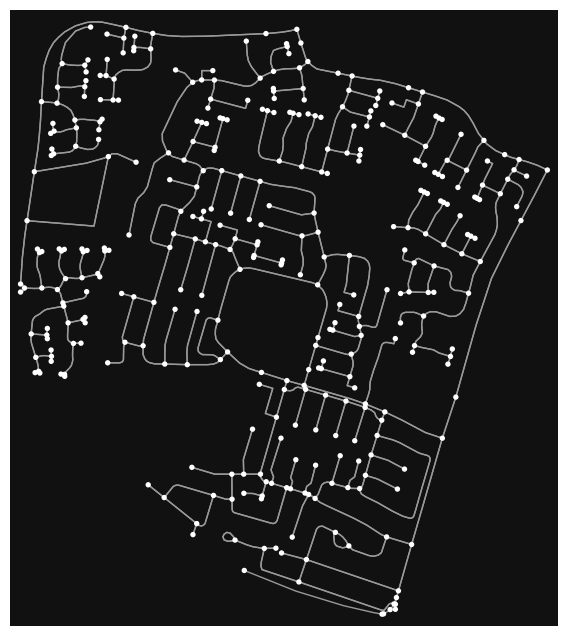

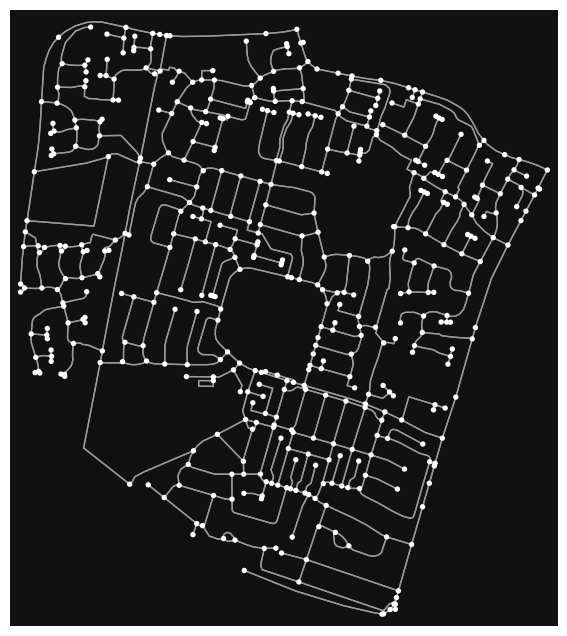

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


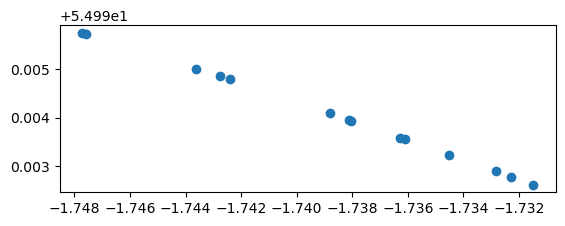

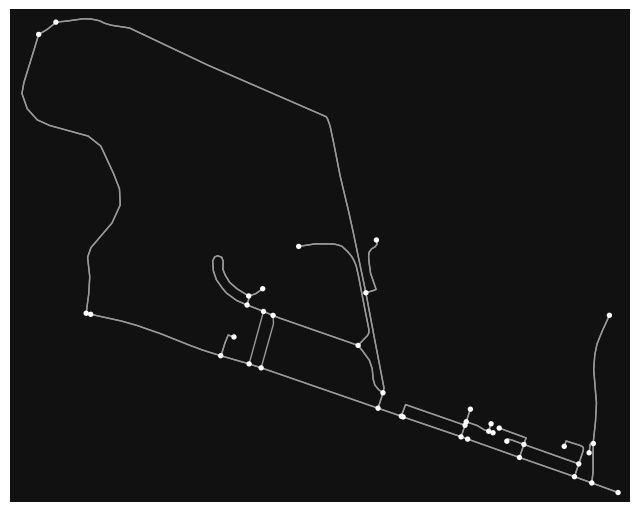

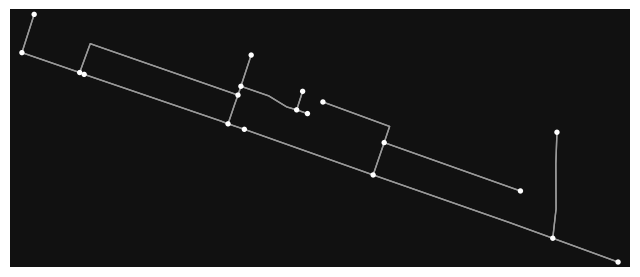

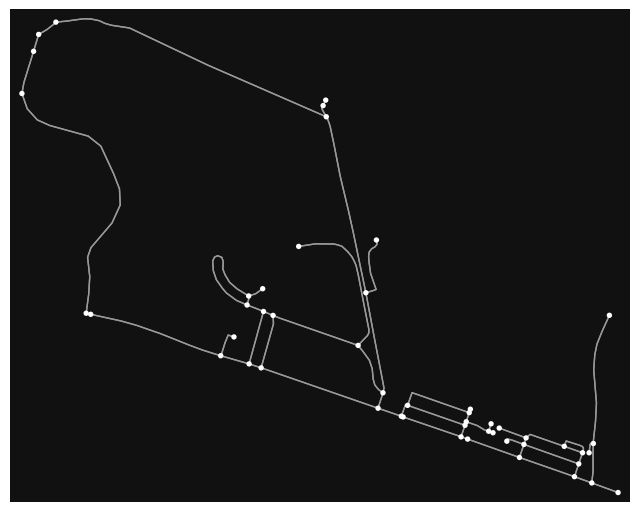

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


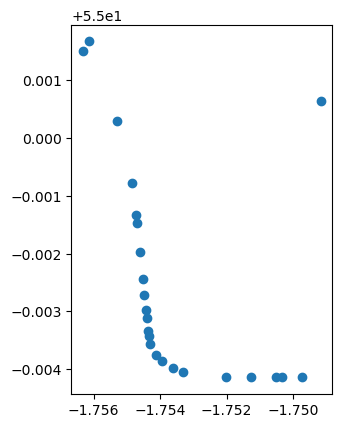

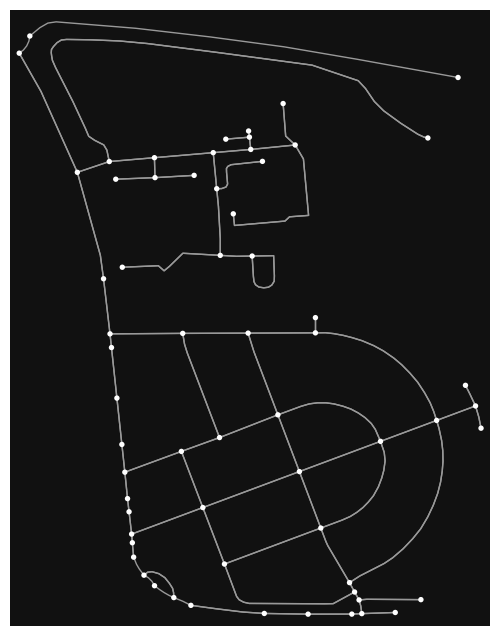

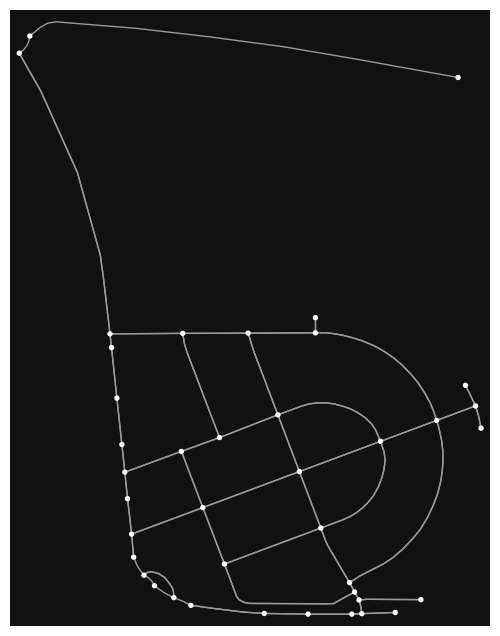

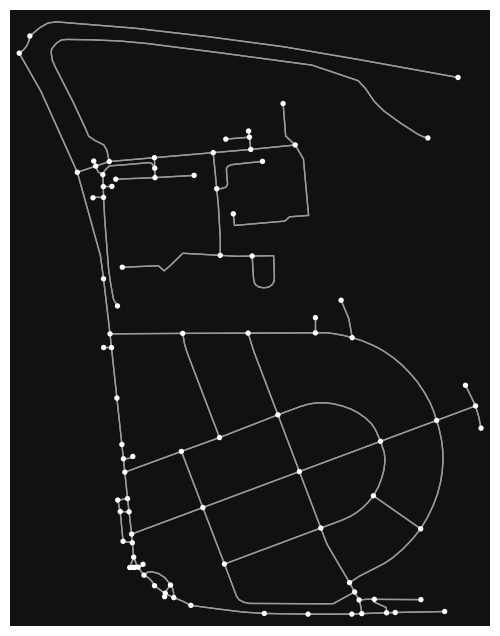

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


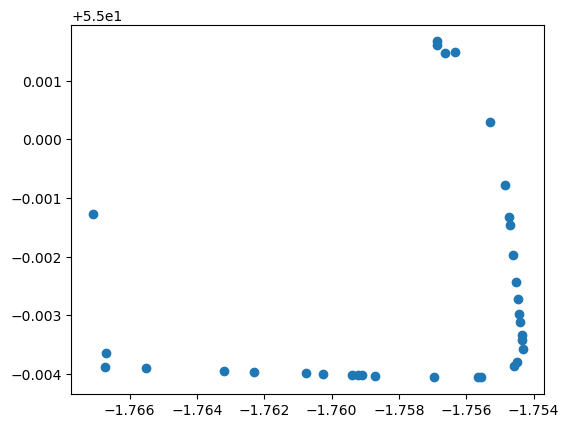

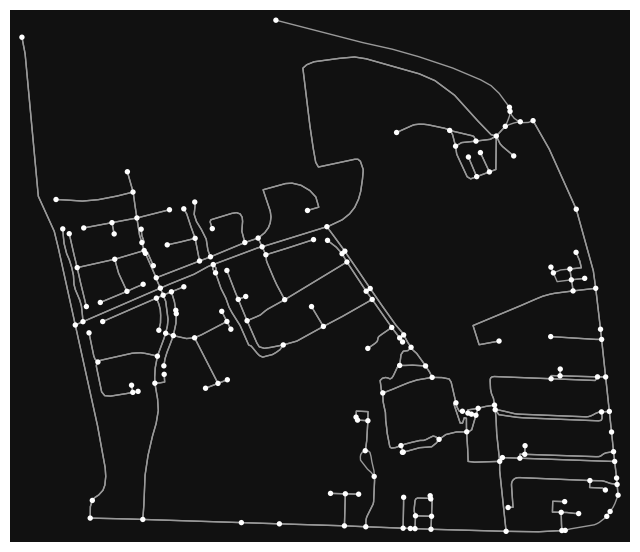

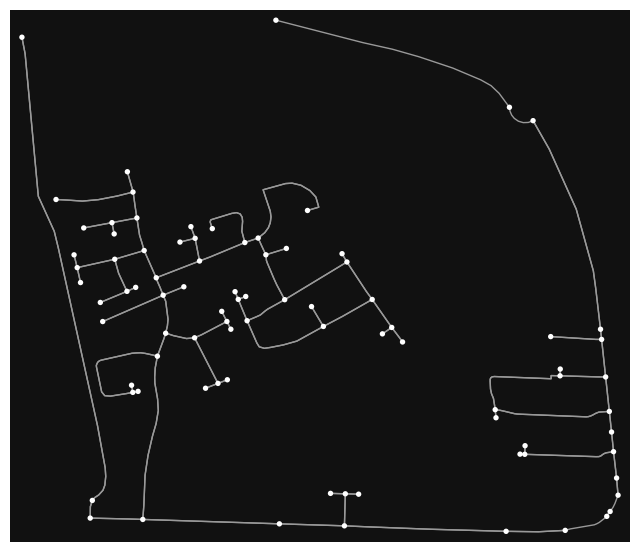

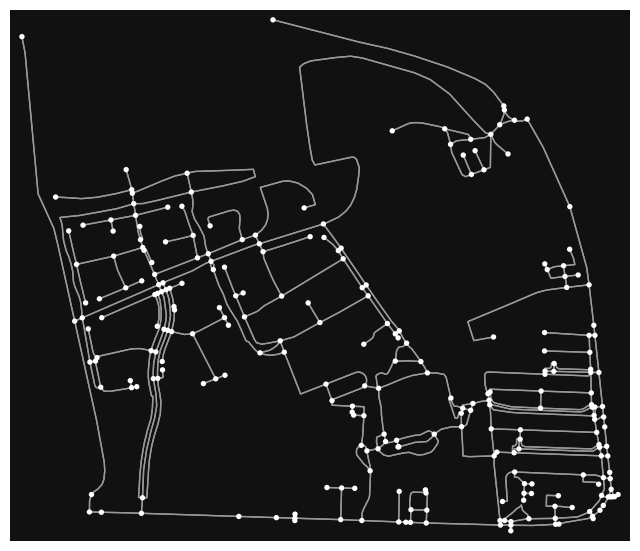

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


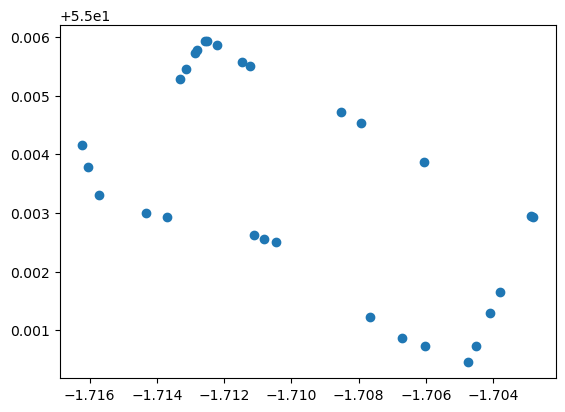

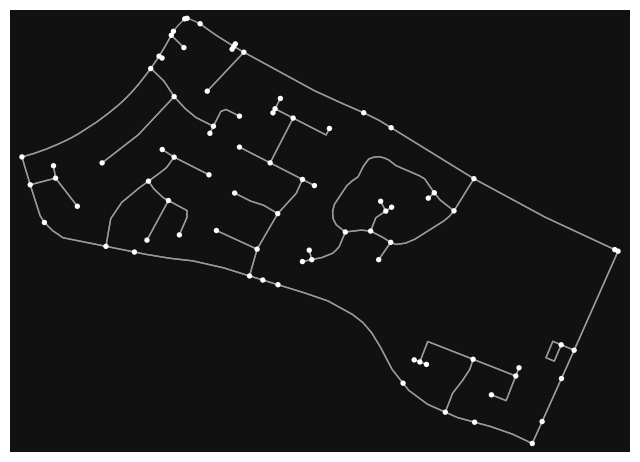

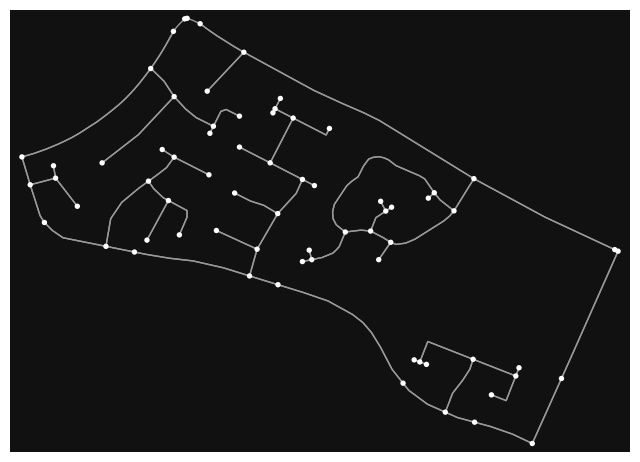

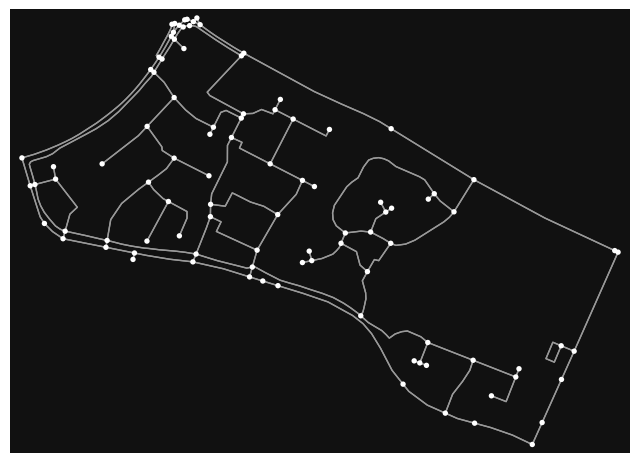

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


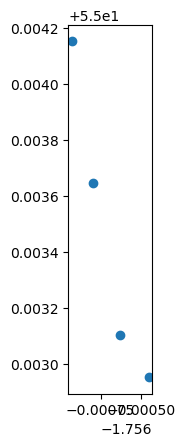

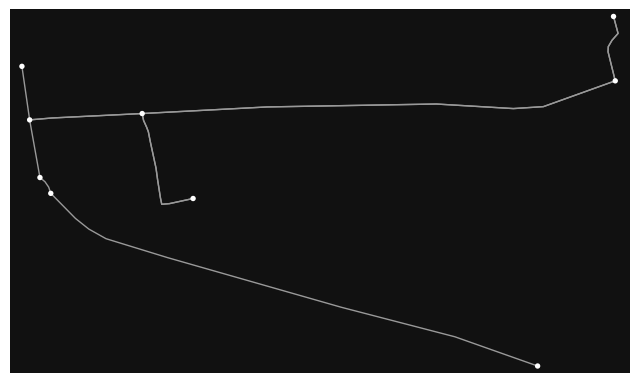

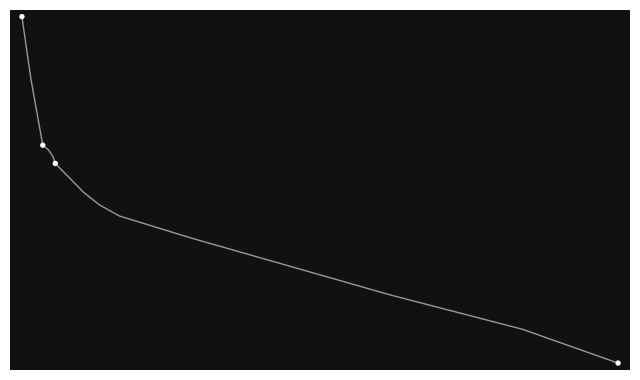

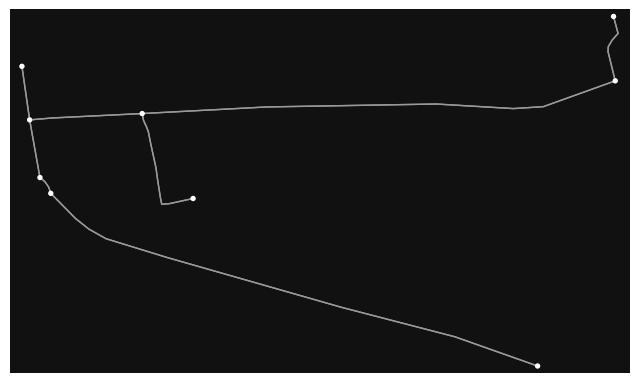

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


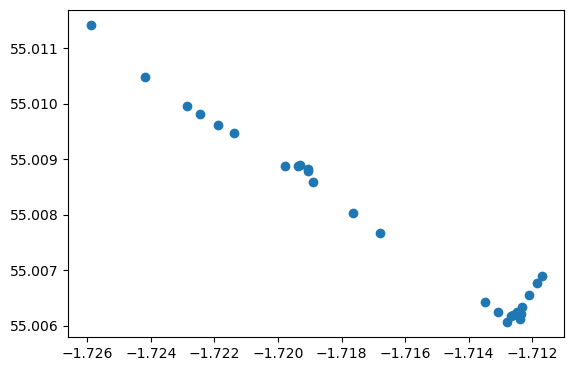

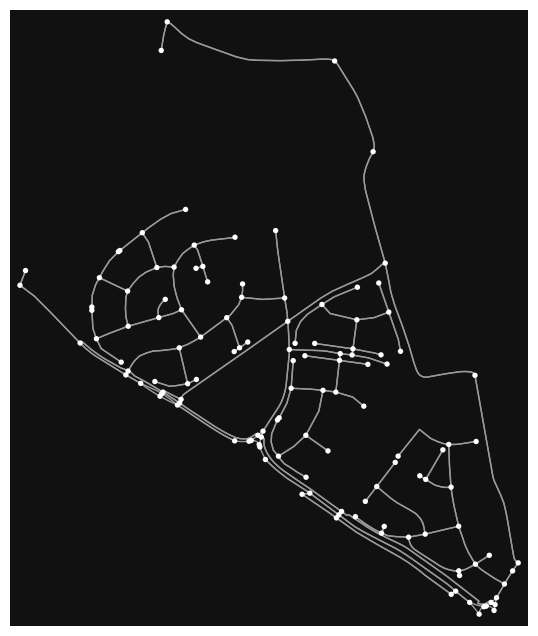

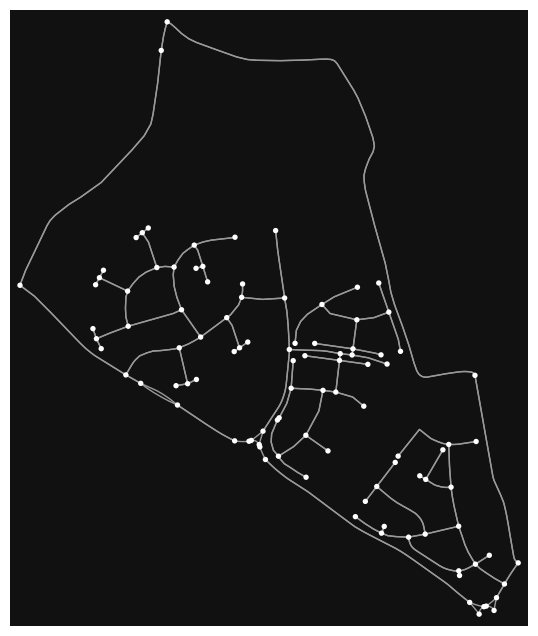

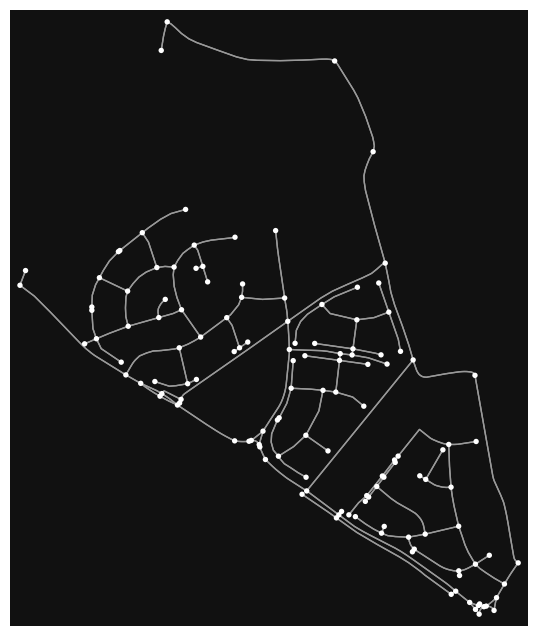

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


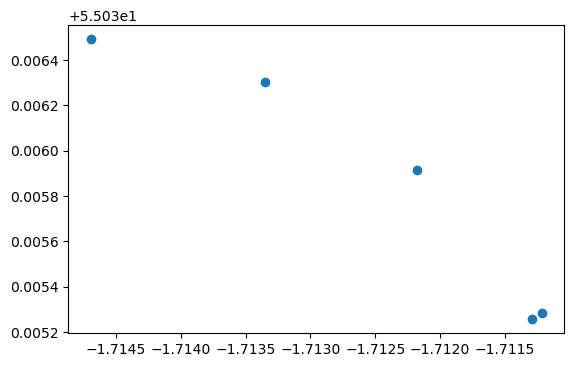

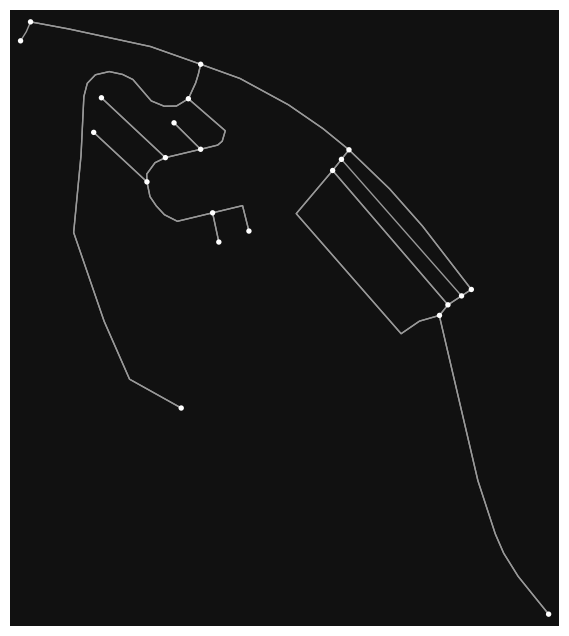

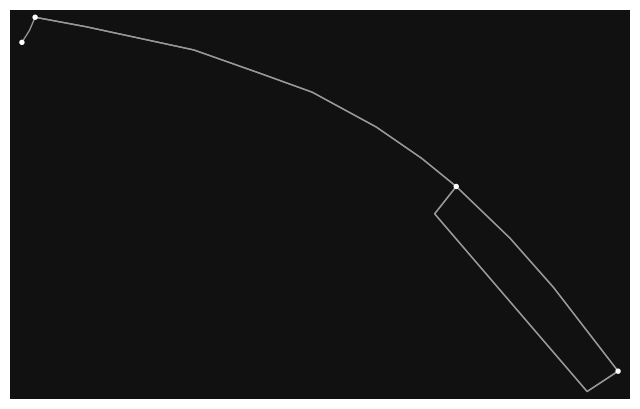

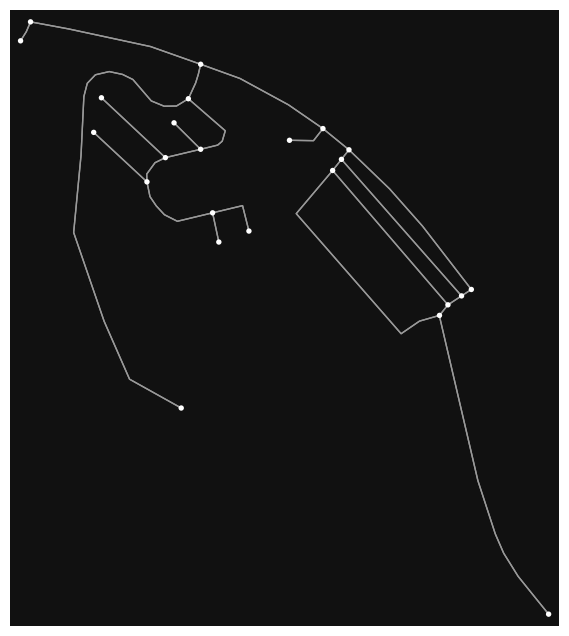

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


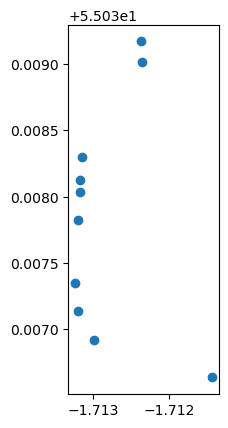

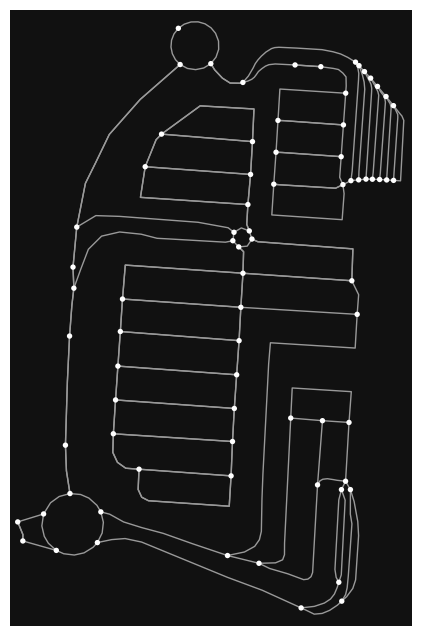

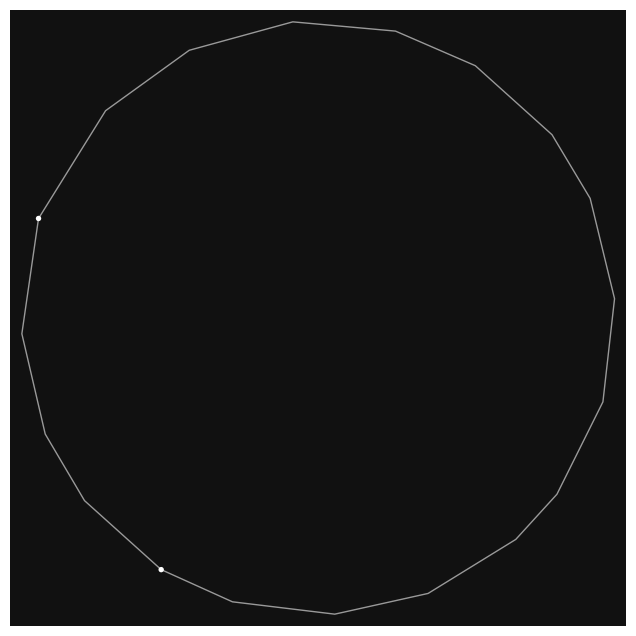

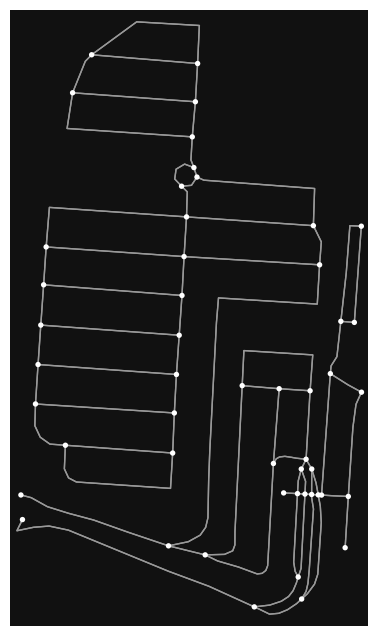

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


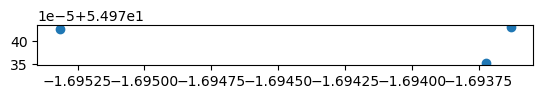

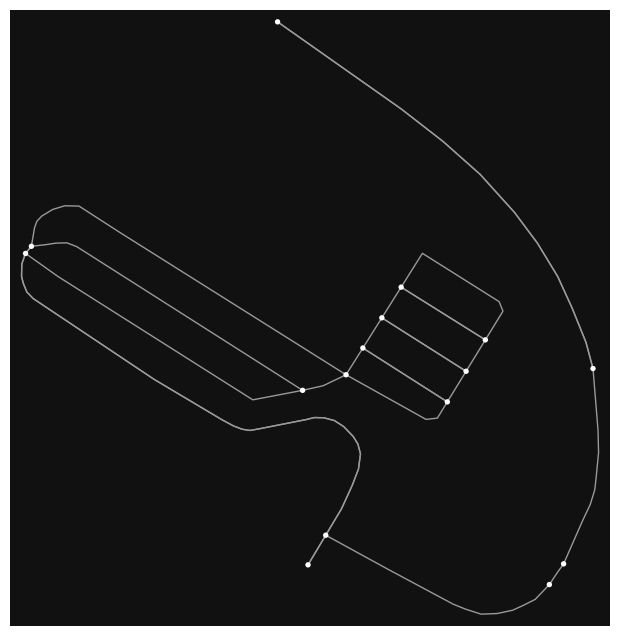

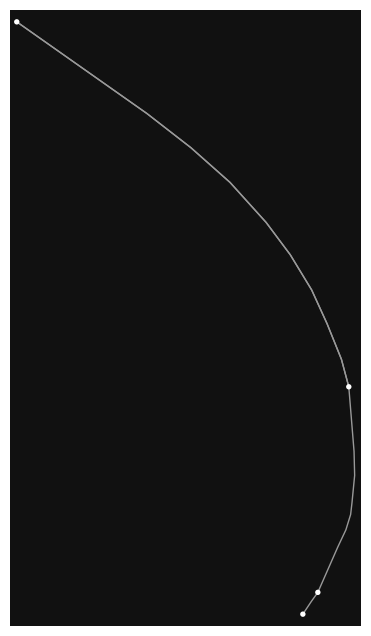

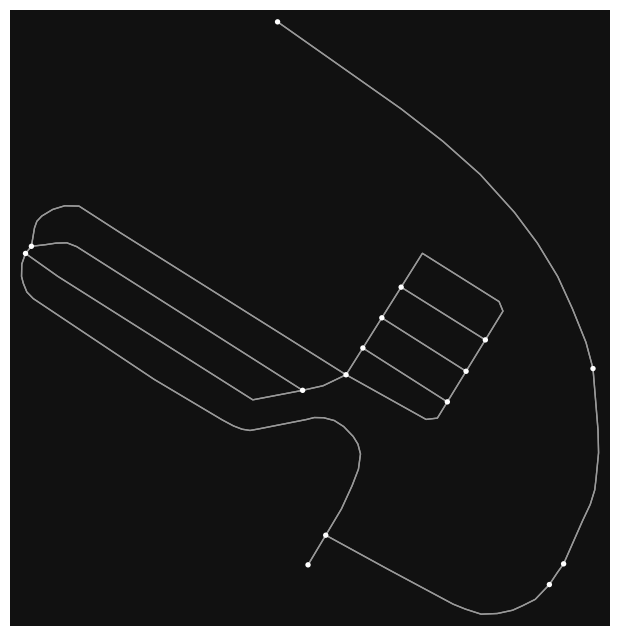

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


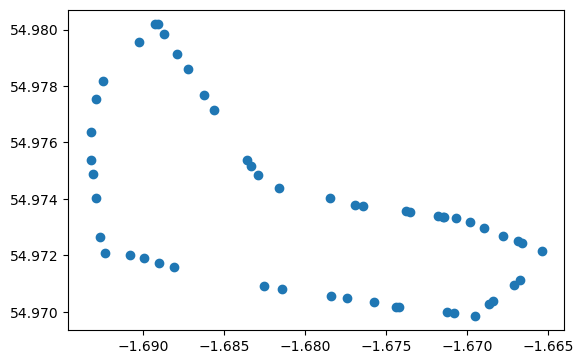

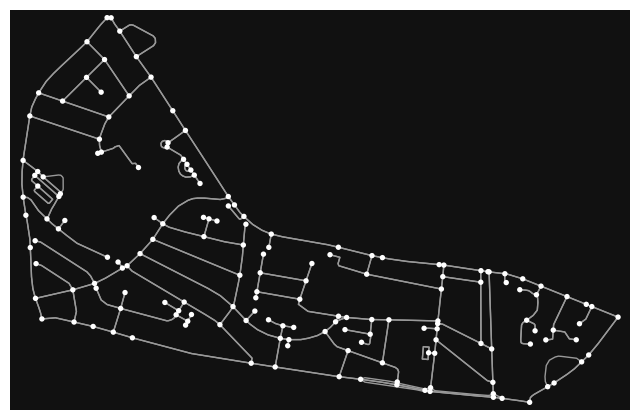

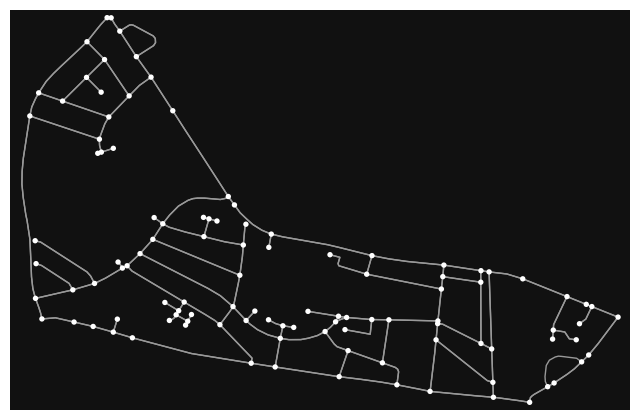

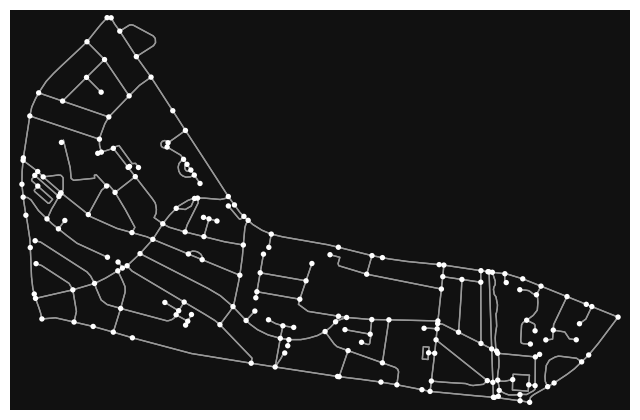

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


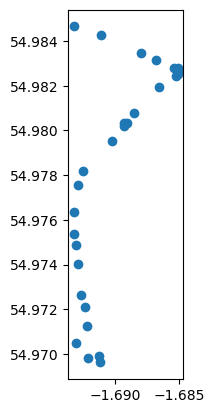

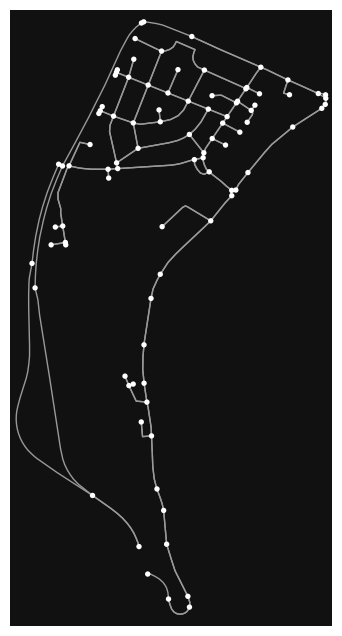

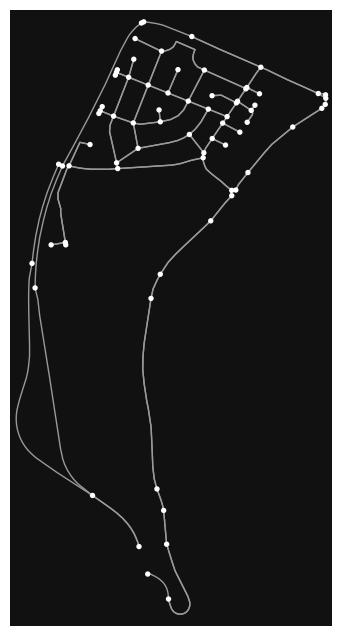

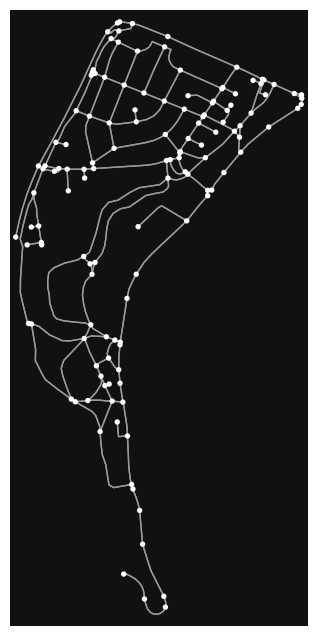

c:\Users\b8008458\Anaconda3\envs\ox_151\Lib\site-packages\IPython\core\interactiveshell.py:3445: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


KeyboardInterrupt: 

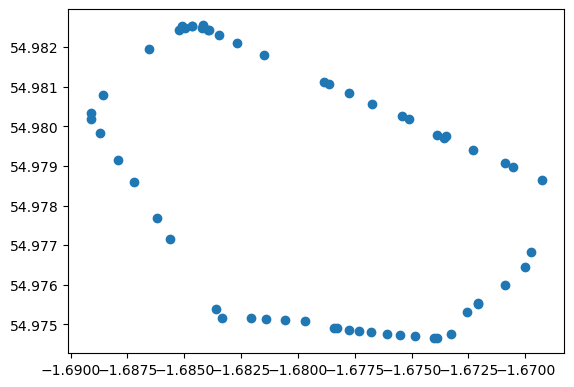

In [140]:
# Assuming 'neighbourhoods' is the geodataframe containing multiple polygons

# Create an empty list to store results for each neighborhood
results = []

for index, row in neighbourhoods.iterrows():
    neighbourhood = neighbourhoods.loc[[index]]

    ### build a network surrounding the neighbourhood

    ## create a buffer around the edge of the neighbourhood to capture boundary roads

    # set crs
    neighbourhood = neighbourhood.to_crs('27700')

    # create a buffer neighbourhood
    neighbourhood_buffer = neighbourhood['geometry'].buffer(15)

    # convert back to a geodataframe (for later on)
    neighbourhood_buffer = gpd.GeoDataFrame(geometry=neighbourhood_buffer)

    # reset crs
    neighbourhood, neighbourhood_buffer = neighbourhood.to_crs('4326'), neighbourhood_buffer.to_crs('4326')


    ## get street network
    streets = ox.graph_from_polygon(neighbourhood_buffer.geometry.iloc[0], network_type='bike')

    # Convert the OSMnx graph to a GeoDataFrame of streets
    streets_edges = ox.graph_to_gdfs(streets, nodes=False, edges=True)
    streets_nodes = ox.graph_to_gdfs(streets, nodes=True, edges=False)







    ### Find only driveable nodes

    #Filter edges with desired 'highway' attributes containing any keyword in drive_highway_types
    drive_highway_types = ['tertiary', 'secondary', 'primary', 'unclassed', 'residential', 'primary_link', 'secondary_link', 'tertiary_link', 'living_street', 'service', 'road']

    # Function to check if any desired keyword is in the 'highway' attribute
    def contains_desired_highway_type(highway_attr):
        for keyword in drive_highway_types:
            if keyword in highway_attr:
                return True
        return False

    # Apply the function to create a boolean mask
    mask = streets_edges['highway'].apply(contains_desired_highway_type)
    driveable_edges = streets_edges[mask]

    # Extract unique node identifiers from the MultiIndex columns 'u' and 'v' of filtered edges
    u_nodes = driveable_edges.index.get_level_values('u').tolist()
    v_nodes = driveable_edges.index.get_level_values('v').tolist()
    driveable_nodes = set(u_nodes + v_nodes)

    # Filter nodes based on their connection to filtered edges
    driveable_nodes_gdf = streets_nodes[streets_nodes.index.isin(driveable_nodes)]










    ## find the boundary roads using 

    # Calculate the difference between neighbourhood_buffer and neighbourhood
    neighbourhood_difference = gpd.overlay(neighbourhood_buffer, neighbourhood, how='difference')

    # find all nodes within the buffer
    boundary_nodes = gpd.sjoin(driveable_nodes_gdf, neighbourhood_difference, how="inner", op='within')

    # Extract nodes from the 'boundary_nodes' index
    nodes_list = list(boundary_nodes.index)







    ## get mode based networks
    bike_streets = ox.graph_from_polygon(neighbourhood_buffer.geometry.iloc[0], network_type='bike')
    walk_streets = ox.graph_from_polygon(neighbourhood_buffer.geometry.iloc[0], network_type='walk')
    drive_streets = ox.graph_from_polygon(neighbourhood_buffer.geometry.iloc[0], network_type='drive')




    walk_stats = calculate_distance_stats(walk_streets)
    bike_stats = calculate_distance_stats(bike_streets)
    drive_stats = calculate_distance_stats(drive_streets)

    # Add the statistics to the GeoDataFrame
    neighbourhood['walk_mean_distance'] = walk_stats['mean_distance']
    neighbourhood['walk_median_distance'] = walk_stats['median_distance']
    neighbourhood['walk_min_distance'] = walk_stats['min_distance']
    neighbourhood['walk_max_distance'] = walk_stats['max_distance']
    neighbourhood['walk_distance_range'] = walk_stats['distance_range']

    neighbourhood['bike_mean_distance'] = bike_stats['mean_distance']
    neighbourhood['bike_median_distance'] = bike_stats['median_distance']
    neighbourhood['bike_min_distance'] = bike_stats['min_distance']
    neighbourhood['bike_max_distance'] = bike_stats['max_distance']
    neighbourhood['bike_distance_range'] = bike_stats['distance_range']

    neighbourhood['drive_mean_distance'] = drive_stats['mean_distance']
    neighbourhood['drive_median_distance'] = drive_stats['median_distance']
    neighbourhood['drive_min_distance'] = drive_stats['min_distance']
    neighbourhood['drive_max_distance'] = drive_stats['max_distance']
    neighbourhood['drive_distance_range'] = drive_stats['distance_range']








    # Store statistics along with neighborhood ID or other identifying information
    result = {
        'neighbourhood_id': neighbourhood['ID'].iloc[0],  # Assuming you have an ID column
        'walk_mean_distance': walk_stats['mean_distance'],
        'walk_median_distance': walk_stats['median_distance'],
        # ... Repeat for other statistics and street types
    }

    results.append(result)

# Convert the results to a new dataframe
results_df = pd.DataFrame(results)
